# Project-2

In [21]:


import sys, subprocess, importlib, os, warnings
warnings.filterwarnings("ignore")

# Function to install missing packages automatically
def ensure(pkg):
    try:
        return importlib.import_module(pkg)
    except ImportError:
        print(f"[INFO] Installing missing package: {pkg} ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
        return importlib.import_module(pkg)

# Core Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
ensure("xgboost")
from xgboost import XGBClassifier

# ------------------------------------------------------------
# Utility function that saves figures in "output_images/" folder
# ------------------------------------------------------------
OUT_DIR = "output_images"
os.makedirs(OUT_DIR, exist_ok=True)

def savefig(path, dpi=220, bbox_inches="tight"):
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, path), dpi=dpi, bbox_inches=bbox_inches)
    print(f"     Saved: {os.path.join(OUT_DIR, path)}")


## Step 1: Load the collected CSV data

I have collected data  and stored them in a CSV file.
Now, I load it into pandas for further processing.


In [22]:
# This tries to find the CSV file automatically from common paths
candidates = [
    "stroop_test_data.csv",
    "./data/stroop_test_data.csv",
    "/mnt/data/stroop_test_data.csv"
]
csv_path = None
for p in candidates:
    if os.path.exists(p):
        csv_path = p
        break

if csv_path is None:
    raise FileNotFoundError("Please place 'stroop_test_data.csv' in the project folder.")

print(f"[INFO] Loaded data from: {csv_path}")
df_raw = pd.read_csv(csv_path)
df_raw.head()


[INFO] Loaded data from: stroop_test_data.csv


,User_ID,Accuracy_Percent,Avg_Reaction_Time_Seconds
0,1,90.6,1.32
1,2,86.2,1.58
2,3,95.7,1.15
3,4,78.3,1.89
4,5,92.0,1.28


## Step 2: Clean and normalize the data

I clean the dataset by:
- Normalizing column names
- Removing duplicates
- Converting values to numeric
- Clipping invalid values (like negative accuracy)


In [23]:
df = df_raw.copy()
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# This auto-detects accuracy and reaction-time columns
col_map = {"accuracy": None, "reaction_time": None}
for c in df.columns:
    if col_map["accuracy"] is None and ("accuracy" in c and "percent" in c):
        col_map["accuracy"] = c
    if col_map["reaction_time"] is None and (("reaction" in c and "time" in c) or c in {"rt","avg_rt","mean_rt"}):
        col_map["reaction_time"] = c

acc_col = col_map["accuracy"]
rt_col  = col_map["reaction_time"]

# Drops duplicates
df = df.drop_duplicates()

# Converts to numeric
df[acc_col] = pd.to_numeric(df[acc_col], errors="coerce")
df[rt_col]  = pd.to_numeric(df[rt_col], errors="coerce")
df = df.dropna(subset=[acc_col, rt_col]).reset_index(drop=True)

# Clip values
df[acc_col] = df[acc_col].clip(0,100)
df[rt_col]  = df[rt_col].clip(lower=1e-6)

print(f"[INFO] Final dataset shape after cleaning: {df.shape}")
df.head()


[INFO] Final dataset shape after cleaning: (20, 3)


,user_id,accuracy_percent,avg_reaction_time_seconds
0,1,90.6,1.32
1,2,86.2,1.58
2,3,95.7,1.15
3,4,78.3,1.89
4,5,92.0,1.28


# Step 2.5: Add Statistical Features


In [24]:
# Mean & Standard Deviation of Accuracy and Reaction Time
df["acc_mean"] = df[acc_col].mean()
df["acc_std"]  = df[acc_col].std()
df["rt_mean"]  = df[rt_col].mean()
df["rt_std"]   = df[rt_col].std()

# Z-score Normalization (how many std away each value is)
df["acc_z"] = (df[acc_col] - df[acc_col].mean()) / df[acc_col].std(ddof=0)
df["rt_z"]  = (df[rt_col] - df[rt_col].mean()) / df[rt_col].std(ddof=0)

# Ratio Feature (accuracy per reaction time)
df["acc_rt_ratio"] = df[acc_col] / df[rt_col]

print("[INFO] Added statistical features. Current shape:", df.shape)
df.head()


[INFO] Added statistical features. Current shape: (20, 10)


,user_id,accuracy_percent,avg_reaction_time_seconds,acc_mean,acc_std,rt_mean,rt_std,acc_z,rt_z,acc_rt_ratio
0,1,90.6,1.32,86.92,6.964164,1.548,0.320207,0.542147,-0.730537,68.636364
1,2,86.2,1.58,86.92,6.964164,1.548,0.320207,-0.106072,0.102531,54.556962
2,3,95.7,1.15,86.92,6.964164,1.548,0.320207,1.293492,-1.275235,83.217391
3,4,78.3,1.89,86.92,6.964164,1.548,0.320207,-1.269920,1.095805,41.428571
4,5,92.0,1.28,86.92,6.964164,1.548,0.320207,0.748399,-0.858701,71.875000


## Step 3: Manual labeling

I have labeled the data manually using a **rule-based approach**:
- If accuracy is very high (≥ 80th percentile), or
- If accuracy is above median and reaction time is faster than median  
👉 Then I label as **High Performer (1)**. Otherwise **Low Performer (0)**.


In [25]:
# This calculates median and 80th percentile for accuracy and reaction time
acc_median = df[acc_col].median()
acc_p80    = df[acc_col].quantile(0.80)
rt_median  = df[rt_col].median()

def make_label(row):
    acc = row[acc_col]
    rt  = row[rt_col]
    if (acc >= acc_p80) or (acc >= acc_median and rt <= rt_median):
        return 1
    return 0

df["label"] = df.apply(make_label, axis=1)
print(df["label"].value_counts())
df.head()


label
1    10
0    10
Name: count, dtype: int64


,user_id,accuracy_percent,avg_reaction_time_seconds,acc_mean,acc_std,rt_mean,rt_std,acc_z,rt_z,acc_rt_ratio,label
0,1,90.6,1.32,86.92,6.964164,1.548,0.320207,0.542147,-0.730537,68.636364,1
1,2,86.2,1.58,86.92,6.964164,1.548,0.320207,-0.106072,0.102531,54.556962,0
2,3,95.7,1.15,86.92,6.964164,1.548,0.320207,1.293492,-1.275235,83.217391,1
3,4,78.3,1.89,86.92,6.964164,1.548,0.320207,-1.269920,1.095805,41.428571,0
4,5,92.0,1.28,86.92,6.964164,1.548,0.320207,0.748399,-0.858701,71.875000,1


## Step 4: Redundant feature detection

I have checked for:
- **Low variance features** (columns with almost constant values)
- **Highly correlated features** (correlation > 0.95)

These are dropped to avoid redundancy.


In [26]:
# this selects numeric columns and identify features to drop based on variance and correlation
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c != "label"]

# Low variance
low_variance_cols = [c for c in feature_cols if df[c].nunique() <= 1]

# High correlation
corr = df[feature_cols].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_corr_pairs = [(c1, c2) for c1 in upper.columns for c2 in upper.columns if (upper.loc[c1,c2] > 0.95)]

# Features to drop
drop_for_corr = {c2 for (c1,c2) in high_corr_pairs}
to_drop = list(set(low_variance_cols) | drop_for_corr)
kept_features = [c for c in feature_cols if c not in to_drop]

print("[INFO] Dropped features:", to_drop)
print("[INFO] Kept features:", kept_features)


[INFO] Dropped features: ['avg_reaction_time_seconds', 'rt_std', 'acc_rt_ratio', 'acc_z', 'rt_z', 'rt_mean', 'acc_mean', 'acc_std']
[INFO] Kept features: ['user_id', 'accuracy_percent']


## Step 5: Train-Test split and scaling

I split the data into training and testing sets (80/20).
I also scale the features for Neural Network.


In [27]:
# Preparing data for training
X = df[kept_features]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

print(f"[INFO] Train size: {len(X_train)}, Test size: {len(X_test)}")


[INFO] Train size: 16, Test size: 4


## Step 6: Model Training

I trained three models:
1. **Neural Network (MLPClassifier)**
2. **Random Forest**
3. **XGBoost**


In [28]:
# Neural Network
nn = MLPClassifier(hidden_layer_sizes=(16,8), activation="relu", max_iter=1000, random_state=42)
nn.fit(X_train_scaled, y_train)

# Random Forest
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

# XGBoost
xgb_clf = XGBClassifier(n_estimators=400, learning_rate=0.07, max_depth=3,
                        subsample=0.9, colsample_bytree=0.9, random_state=42, eval_metric="logloss")
xgb_clf.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


## Step 7: Model Evaluation

I have shown **Confusion Matrices** and **Classification Reports** for all three models.  
All images will be automatically saved in the `output_images` folder.


Neural Network Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

Random Forest Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4

XGBoost Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted a

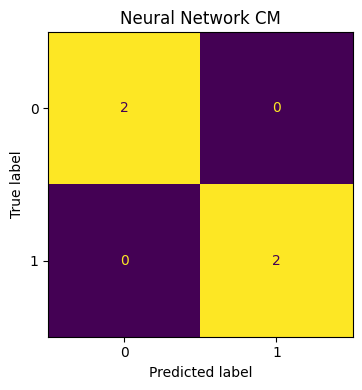

     Saved: output_images\RF_CM.jpg


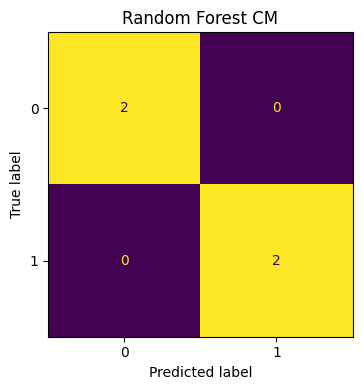

     Saved: output_images\XGB_CM.jpg


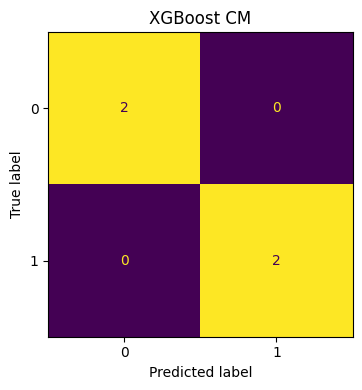

     Saved: output_images\Confusion_Matrix.jpg


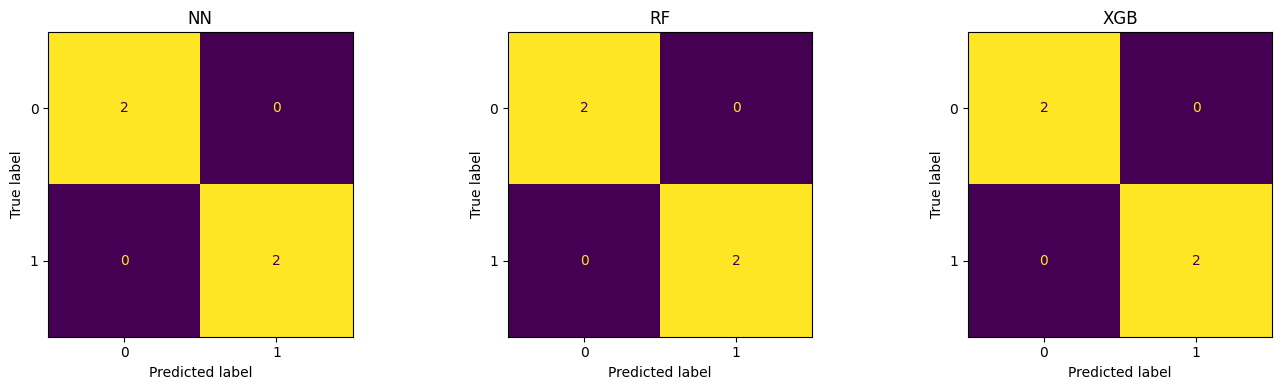

In [29]:
# Predictions
y_pred_nn  = nn.predict(X_test_scaled)
y_pred_rf  = rf.predict(X_test)
y_pred_xgb = xgb_clf.predict(X_test)

print("Neural Network Report:\n", classification_report(y_test, y_pred_nn))
print("Random Forest Report:\n", classification_report(y_test, y_pred_rf))
print("XGBoost Report:\n", classification_report(y_test, y_pred_xgb))

# Confusion matrix plotting
def plot_and_save_cm(y_true, y_pred, title, fname):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(4.5,4))
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(title)
    savefig(fname)
    plt.show()

plot_and_save_cm(y_test, y_pred_nn,  "Neural Network CM", "NN_CM.jpg")
plot_and_save_cm(y_test, y_pred_rf,  "Random Forest CM", "RF_CM.jpg")
plot_and_save_cm(y_test, y_pred_xgb, "XGBoost CM", "XGB_CM.jpg")

# Combined Confusion Matrix
fig, axes = plt.subplots(1, 3, figsize=(14,4))
for ax, (title, preds) in zip(axes, [("NN",y_pred_nn), ("RF",y_pred_rf), ("XGB",y_pred_xgb)]):
    cm = confusion_matrix(y_test, preds, labels=[0,1])
    disp = ConfusionMatrixDisplay(cm, display_labels=[0,1])
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(title)
savefig("Confusion_Matrix.jpg")
plt.show()


## Step 8: Data Visualization

Finally, I created a scatter plot of the collected data.
This shows **accuracy vs reaction time**, colored by manual labels.


     Saved: output_images\Data_Visualize.jpg


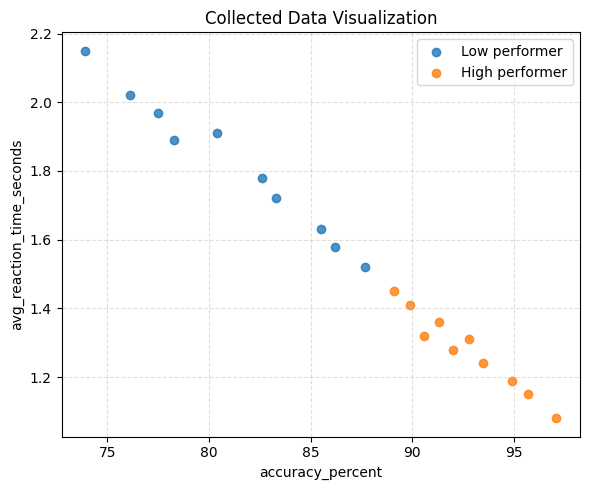

In [30]:
plt.figure(figsize=(6,5))

for label_val, label_name in [(0, "Low"), (1, "High")]:
    mask = (df["label"] == label_val)
    plt.scatter(df.loc[mask, acc_col], df.loc[mask, rt_col],
                alpha=0.8, label=f"{label_name} performer")

plt.xlabel(acc_col)
plt.ylabel(rt_col)
plt.title("Collected Data Visualization")
plt.legend()
plt.grid(True, ls="--", alpha=0.4)
savefig("Data_Visualize.jpg")
plt.show()
